This notebook shows an example of producing a plot of Signal Efficiency vs Background Rejection for a certain process and mass, and for customizable cut parameters.

# Imports

In [1]:
import uproot4
import uproot
import awkward1 as ak
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)

# Files 

Background

In [2]:
root = uproot4.concatenate("../../../../2017Data/combined_data/track_*.root:save/rawEvent",["fTriggerBits","fAllHits.pos","fAllHits.driftDistance","fAllHits.detectorID"],library="ak",how="zip")

Signal

In [3]:
# names 
Brem003 = "../../../../electrons/sim_eval_Brem_0.033428_z500_600_eps_-5.2.root"
Brem047 = "../../../../electrons/sim_eval_Brem_0.470915_z500_600_eps_-6.root"
Eta001 = "../../../../electrons/sim_eval_Eta_0.019564_z500_600_eps_-5.2.root"
Eta054 = "../../../../electrons/sim_eval_Eta_0.540000_z500_600_eps_-6.root"

# Get Background Data

In [4]:
def get_BackgroundData(root):
    bg_events = ak.zip({"Hits":ak.zip({
                                        "detectorID": root.fAllHits["detectorID"],
                                        "pos": root.fAllHits["pos"]
                                      })
                       }, depth_limit=1)
    return bg_events

def H1BT(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 31) & (arr.detectorID <= 32)
    else:
        mask = (arr.detID >= 31) & (arr.detID <= 32)
    return mask

def H1LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 33) & (arr.detectorID <= 34)
    else:
        mask = (arr.detID >= 33) & (arr.detID <= 34)
    return mask

def H2BT(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 37) & (arr.detectorID <= 38)
    else:
        mask = (arr.detID >= 37) & (arr.detID <= 37)
    return mask

def H2LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 35) & (arr.detectorID <= 36)
    else:
        mask = (arr.detID >= 35) & (arr.detID <= 36)
    return mask

def H4BT(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 45) & (arr.detectorID <= 46)
    else:
        mask = (arr.detID >= 45) & (arr.detID <= 46)
    return mask

def H4Y1LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 41) & (arr.detectorID <= 42)
    else:
        mask = (arr.detID >= 41) & (arr.detID <= 42)
    return mask

def H4Y2LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 43) & (arr.detectorID <= 44)
    else:
        mask = (arr.detID >= 43) & (arr.detID <= 44)
    return mask

def layer4_BG(root,pos1=-10,pos2=10,pos3=-10,pos4=10,pos5=-10,pos6=10):
    '''impose cuts on BG data'''
    # get all events
    allHits = get_BackgroundData(root)["Hits"]
    # get all valid events based on TriggerBits criteria (random trigger)
    validEvent_fTriggerBits = (root.fTriggerBits==65) | (root.fTriggerBits==67)
    # now mask all events by TriggerBits
    hitsBG = allHits[validEvent_fTriggerBits]
    
    # cut on station 1
    h1_mask = H1BT(hitsBG)
    h1_hits = hitsBG[h1_mask]
    x1_mask = (h1_hits.pos >= pos1) & (h1_hits.pos <= pos2)
    x1_index = np.where(ak.any(x1_mask,axis=1))   # indices of all events meeting st1 criteria
    n1 = len(ak.flatten(x1_index))   # number of valid events after cut 1
    
    # cut on station 2
    h2_mask = H2BT(hitsBG)
    h2_hits = hitsBG[h2_mask]
    x2_mask = (h2_hits.pos >= pos3) & (h2_hits.pos <= pos4)
    x2_index = np.where(ak.any(x2_mask,axis=1))   # indices of all events meeting st2 criteria
    # get indices of events meeting st1 AND st2 criteria
    x1x2_index = np.intersect1d(x1_index,x2_index)   # we use this to plot H2BT/H2LR
    n2 = len(x1x2_index)   # number of valid events after cut1 and cut2
    
    '''
    print(h2_mask)
    print(np.sum(h2_mask))
    print(x2_mask)
    print(x2_index)
    print(np.sum(x2_index))
    print(x1x2_index)
    '''
    
    # cut on station 4
    h4_mask = H4BT(hitsBG)
    h4_hits = hitsBG[h4_mask]
    x4_mask = (h4_hits.pos >= pos5) & (h4_hits.pos <= pos6)
    x4_index = np.where(ak.any(x4_mask,axis=1))
    # get indices of valid events meeting all 3 criteria
    final_index = np.intersect1d(x1x2_index,x4_index)    # we use this to plot H4s
    n4 = len(final_index)
    
    # get L/R hodos
    h1lr = H1LR(hitsBG)
    h2lr = H2LR(hitsBG)
    h4y1lr = H4Y1LR(hitsBG)
    h4y2lr = H4Y2LR(hitsBG)
    
    h1lr_hits = hitsBG[h1lr]
    h2lr_hits = hitsBG[h2lr]
    h4y1lr_hits = hitsBG[h4y1lr]
    h4y2lr_hits = hitsBG[h4y2lr]
    
    # now use the appropriate x?_index array to get the valid entries 
    # return a list of each detector [uncut,cut,nevents_cut] -> needs to be flattened
    return [[h1_hits.pos,h1_hits[x1_index].pos,n1],         # H1Bt
            [h2_hits.pos,h2_hits[x1x2_index].pos,n2],       # H2BT
            [h4_hits.pos,h4_hits[x4_mask].pos,n4],          # H4BT
            [h1lr_hits.pos,h1lr_hits[x1_index].pos,n1],     # H1LR
            [h2lr_hits.pos,h2lr_hits[x1x2_index].pos,n2],   # H2LR
            [h4y1lr_hits.pos,h4y1lr_hits[x4_index].pos,n4], # H4Y1LR
            [h4y2lr_hits.pos,h4y2lr_hits[x4_index].pos,n4]] # H4Y2LR

# Get Signal Data

In [5]:
def getDataSim(fname="", procName="Truth"):
    dq_dict = uproot.open(fname)["Truth"]
    dq_events = ak.zip({"Hits":ak.zip({
                                      "detID":   dq_dict["hit_detID"].array(),
                                      "edep":    dq_dict["hit_edep"].array(),
                                      "elmID":   dq_dict["hit_elmID"].array(),
                                      "truthx":  dq_dict["hit_truthx"].array(),
                                      "truthy":  dq_dict["hit_truthy"].array(),
                                      "truthz":  dq_dict["hit_truthz"].array(),
                                      })
                        }, depth_limit=1)
    
    return dq_events

Get the actual data from the simulation ROOT files

In [6]:
# actual file
Truth003 = getDataSim(Brem003)["Hits"]
Truth047 = getDataSim(Brem047)["Hits"]
Truth001 = getDataSim(Eta001)["Hits"]
Truth054 = getDataSim(Eta054)["Hits"]

In [7]:
def layer4Sim(root,pos1=-10,pos2=10,pos3=-10,pos4=10,pos5=-10,pos6=10):
    '''
    pass the full ROOT file into this function
    '''
    hits = root   # just for ease of not having to change everything..
    
    h1_mask = H1BT(hits,data="signal")
    h1_hits = hits[h1_mask]
    x1_mask = (h1_hits.truthx >= pos1) & (h1_hits.truthx <= pos2)
    x1_index = np.where(ak.any(x1_mask,axis=1))
    nvalid1 = len(ak.flatten(x1_index))   # number of valid events after cut 1
    
    h2_mask = H2BT(hits,data="signal")
    h2_hits = hits[h2_mask]
    x2_mask = (h2_hits.truthx >= pos3) & (h2_hits.truthx <= pos4)
    x2_index = np.where(ak.any(x2_mask,axis=1))
    # get indices of valid events meeting all criteria
    indices = np.intersect1d(x1_index,x2_index)
    nvalid2 = len(indices)

    h4_mask = H4BT(hits,data="signal")
    h4_hits = hits[h4_mask]
    x4_mask = (h4_hits.truthx >= pos5) & (h4_hits.truthx <= pos6)
    x4_index = np.where(ak.any(x4_mask,axis=1))
    # get indices of valid events meeting all criteria
    valid = np.intersect1d(indices,x4_index)
    nvalid4 = len(valid)

    # get the LR hodos
    h1lr = H1LR(hits,data="signal")
    h2lr = H2LR(hits,data="signal")
    h4y1lr = H4Y1LR(hits,data="signal")
    h4y2lr = H4Y2LR(hits,data="signal")
    
    h1lr_hits = hits[h1lr]
    h2lr_hits = hits[h2lr]
    h4y1lr_hits = hits[h4y1lr]
    h4y2lr_hits = hits[h4y2lr]

    # now use the appropriate x?_index array to get the valid entries 
    # return a list of each detector [uncut,cut,nevents_cut] -> needs to be flattened
    return [[h1_hits.truthx,h1_hits[x1_index].truthx,nvalid1],         # H1Bt
            [h2_hits.truthx,h2_hits[indices].truthx,nvalid2],          # H2BT
            [h4_hits.truthx,h4_hits[x4_mask].truthx,nvalid4],          # H4BT
            [h1lr_hits.truthy,h1lr_hits[x1_index].truthy,nvalid1],     # H1LR
            [h2lr_hits.truthy,h2lr_hits[indices].truthy,nvalid2],     # H2LR
            [h4y1lr_hits.truthy,h4y1lr_hits[x4_index].truthy,nvalid4], # H4Y1LR
            [h4y2lr_hits.truthy,h4y2lr_hits[x4_index].truthy,nvalid4]] # H4Y2LR


# ROC Curve

In [8]:
def efficiencies(bg, sim, num=100, cut1=(10,1), cut2=(10,1), cut4=(10,1)):
    '''
    Returns arrays of signal efficiency and background rejection for each of the three layers cut over a given array of x-ranges
    bg = background data ROOT file
    sim = signal data ROOT file
    num = number of different cuts to make
    cut_ = bounds for making the cuts at each station (larger, smaller) inclusive 
        i.e. If you want to cuts from -100,100cm down to -1,1cm on station 1 -> cut1=(100,1)
    '''
    # generate the bounds
    b1 = np.linspace(cut1[0],cut1[1],num=num)
    b2 = np.linspace(cut2[0],cut2[1],num=num)
    b4 = np.linspace(cut4[0],cut4[1],num=num)
    
    # arrays to hold the SE and BR values for each cut -> will be merged into three shape (2,xrange) arrays at the end
    st1_SE = np.array([])
    st1_BR = np.array([])
    st2_SE = np.array([])
    st2_BR = np.array([])
    st4_SE = np.array([])
    st4_BR = np.array([])
    
    # loop through x-ranges, perform cuts 
    for i in range(num):
        bkg_data = layer4_BG(bg, pos1=-b1[i], pos2=b1[i], pos3=-b2[i], pos4=b2[i], pos5=-b4[i], pos6=b4[i])
        #print("bkg done")
        sim_data = layer4Sim(sim, pos1=-b1[i], pos2=b1[i], pos3=-b2[i], pos4=b2[i], pos5=-b4[i], pos6=b4[i]) 
        #print("sim done")
        
        # get the SEs
        SE1 = sim_data[0][2]/10000       # caclulate SE at st1
        st1_SE = np.append(st1_SE, SE1)  # append it to array
        SE2 = sim_data[1][2]/10000
        st2_SE = np.append(st2_SE, SE2)
        SE4 = sim_data[2][2]/10000
        st4_SE = np.append(st4_SE, SE4)
        
        # get the BRs
        BR1 = 1 - bkg_data[0][2]/677
        st1_BR = np.append(st1_BR, BR1)
        BR2 = 1 - bkg_data[1][2]/677
        st2_BR = np.append(st2_BR, BR2)
        BR4 = 1 - bkg_data[2][2]/677
        st4_BR = np.append(st4_BR, BR4)
    
    # return three arrays, each of the form [SE,BR], for stations 1 2 4
    return np.array([st1_SE,st1_BR]), np.array([st2_SE,st2_BR]), np.array([st4_SE,st4_BR])

In [9]:
def plot_efficiencies(st1,st2,st4,name):
    '''
    pass the three arrays of shape (2,xrange)
    pass the name of the sim file used
    '''
    # get process and mass
    mass = name.split("_")[3][0:4] + " MeV"
    proc = name.split("_")[2]
    
    # get data
    st1_SE = st1[0]
    st1_BR = st1[1]
    st2_SE = st2[0]
    st2_BR = st2[1]
    st4_SE = st4[0]
    st4_BR = st4[1]
    
    # plot
    plt.plot(st1_SE, st1_BR, "-b", label="ST1")
    plt.plot(st2_SE, st2_BR, "-r", label="ST2")
    plt.plot(st4_SE, st4_BR, "-g", label="ST4")
    plt.title("Signal Efficiency vs Background Rejection {} {}".format(proc,mass))
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Rejection")
    plt.legend(loc='upper right')
    #plt.savefig("efficiencies_{}".format(proc))

In [12]:
st1,st2,st4 = efficiencies(root,Truth054,num=100,cut1=(100,0.5),cut2=(1000,1000),cut4=(1000,1000))

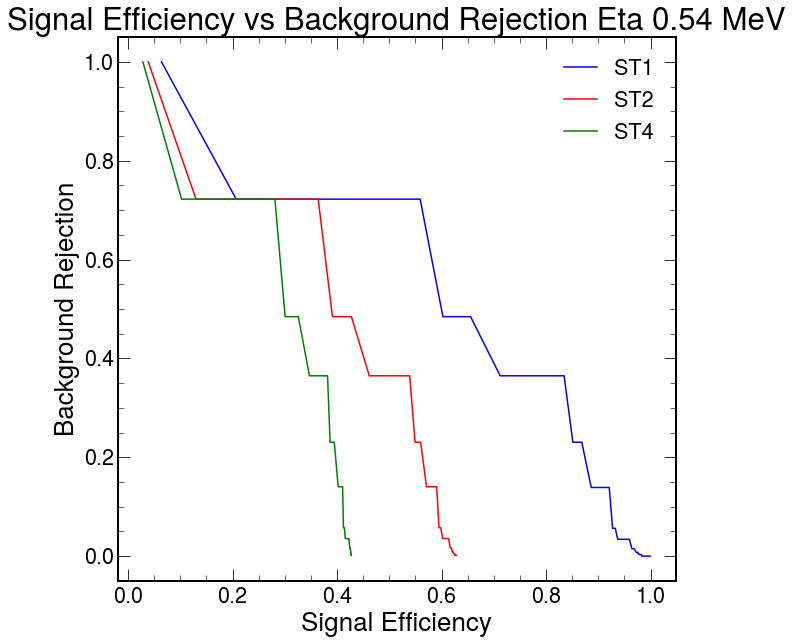

In [13]:
plot_efficiencies(st1,st2,st4,Eta054)

Where 

$$\text{Background Rejection} = 1-\frac{\text{valid background events}}{\text{total events}}$$

$$\text{Signal Efficiency} = \frac{\text{valid signal events}}{\text{total events}}$$